# Loading data and libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from tqdm import tqdm 
from scipy.fft import fft, fftfreq
from scipy import signal

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

C:\Users\ankur\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
audio_files = glob('C:/Users/ankur/OneDrive/Desktop/bib_project/dataset/signals/*.npy')
print(audio_files[0].replace("\\", "/"))

data = np.load(audio_files[0].replace("\\", "/"))


C:/Users/ankur/OneDrive/Desktop/bib_project/dataset/signals/ns011a_1.npy


In [8]:
sr = 4000
audio_signals = {}
for audio_file in audio_files:
  audio_signals[(audio_file.replace("\\","/").split('/')[-1].split('.')[0])]  = np.load(audio_file)[:, 0]

In [10]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
from tqdm import tqdm 
label_files = glob('C:/Users/ankur/OneDrive/Desktop/bib_project/dataset/labels/*.csv')

gulp_data = pd.DataFrame()
for csv in tqdm(label_files):
  gulp_datum = pd.read_csv(csv)
  gulp_datum['audio'] = csv.replace("\\","/").split('/')[-1].split('.')[0]
  gulp_datum['total_start_sec'] = gulp_datum.start.astype(int)
  gulp_datum['total_stop_sec'] = gulp_datum.end.astype(int)
  gulp_data = gulp_data.append(gulp_datum)
gulp_data

100%|██████████| 1282/1282 [00:09<00:00, 128.51it/s]


participant file_num  swallow_num start   end  duration  fnames     audio  \
0        NS011        a          1.0   152   234      82.0  ns011a  ns011a_1   
1        NS011        a          2.0   252   329      77.0  ns011a  ns011a_1   
2        NS011        a          3.0   358   442      84.0  ns011a  ns011a_1   
0        NS011        a          4.0   175   241      66.0  ns011a  ns011a_2   
1        NS011        a          5.0   309   360      51.0  ns011a  ns011a_2   
..         ...      ...          ...   ...   ...       ...     ...       ...   
0         S048        c          1.0   191   237      46.0   s048c   s048c_1   
0         S048        d          1.0   102   160      58.0   s048d   s048d_1   
0         S048        e          1.0   311   355      44.0   s048e   s048e_1   
1         S048        e          2.0   761   805      44.0   s048e   s048e_1   
2         S048        e          3.0  1091  1131      40.0   s048e   s048e_1   

    total_start_sec  total_stop_sec  
0               152             234  
1               252             329  
2               358             442  
0               175             241  
1               309             360  
..              ...             ...  
0               191             237  
0               102             160  
0               311             355  
1               761             805  
2              1091            1131  

[1868 rows x 10 columns]

In [19]:
frame_time = 16
frame_size = int(sr * frame_time / 1000)

overlap_per = 50
overlap_time = frame_time * overlap_per / 100
overlap = int(frame_size * overlap_per / 100)

print(f"Frame size: {frame_size}")
print(f"Frame time in milliseconds: {frame_time}ms")

print(f"Overlap time in milliseconds: {overlap_time}")
print(f"Overlap size: {overlap}")

Frame size: 64
Frame time in milliseconds: 16ms
Overlap time in milliseconds: 8.0
Overlap size: 32


In [20]:
comprehensive_centroid = {}
comprehensive_mfccs = {}
comprehensive_lfccs = {}
comprehensive_zcr = {}
comprehensive_rf = {}

comprehensive_features = {}
for audio_signal in audio_signals.keys():
  # MFCCS
  mfccs = librosa.feature.mfcc(audio_signals[audio_signal], n_mfcc=13, sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_mfccs = librosa.feature.delta(mfccs)
  delta_mfccs_2 = librosa.feature.delta(mfccs, order=2)
  comprehensive_mfccs[audio_signal] = np.concatenate((mfccs, delta_mfccs, delta_mfccs_2))
  
  # LFCCS
  lfccs = lfcc(y=audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_lfccs = librosa.feature.delta(lfccs)
  delta_lfccs_2 = librosa.feature.delta(lfccs, order=2)
  comprehensive_lfccs[audio_signal] = np.concatenate((lfccs, delta_lfccs, delta_lfccs_2))

  # Zero Crossing Rate
  zcr = librosa.feature.zero_crossing_rate(audio_signals[audio_signal], frame_length=frame_size, hop_length=overlap)
  delta_zcr = librosa.feature.delta(zcr)
  delta_zcr_2 = librosa.feature.delta(zcr, order=2)
  comprehensive_zcr[audio_signal] = np.concatenate((zcr, delta_zcr, delta_zcr_2))

  # Roll off
  rf = librosa.feature.spectral_rolloff(audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_rf = librosa.feature.delta(rf)
  delta_rf_2 = librosa.feature.delta(rf, order=2)
  comprehensive_rf[audio_signal] = np.concatenate((rf, delta_rf, delta_rf_2))

  # Centroid
  centroid = librosa.feature.spectral_centroid(audio_signals[audio_signal], sr=sr, n_fft=frame_size, hop_length=overlap)
  delta_centroid = librosa.feature.delta(centroid)
  delta_centroid_2 = librosa.feature.delta(centroid, order=2)
  comprehensive_centroid[audio_signal] = np.concatenate((centroid, delta_centroid, delta_centroid_2))

  # All Features
  comprehensive_features[audio_signal] = np.concatenate((mfccs, delta_mfccs, delta_mfccs_2,
                                           lfccs, delta_lfccs, delta_lfccs_2,
                                           zcr, delta_zcr, delta_zcr_2,
                                           rf, delta_rf, delta_rf_2,
                                           centroid, delta_centroid, delta_centroid_2))

comprehensive_features

C:\Users\ankur\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


NameError: name 'lfcc' is not defined

In [17]:
frames = np.concatenate(tuple(comprehensive_features.values()), axis=1).T
frames.shape

(1437124, 108)

In [9]:
from sklearn import mixture

index = np.arange(len(frames))
np.random.shuffle(index)

test_ratio = 0.8

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

gmm = mixture.GaussianMixture(n_components=2)
gmm.fit(frames[train_idx])

GaussianMixture(n_components=2)

In [ ]:
gmm.score(frames[test_idx])

-75.62565043477652

In [ ]:
gmm.converged_

True

In [1]:
512*512

262144

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

def get_silhouette_score(X, k):
    model = KMeans(k, random_state=37)
    model.fit(X)
    labels = model.predict(X)
    score = silhouette_score(X, labels)
    return score

def get_gmm_score(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    gmm_scores = gmm.score_samples(X)
    score = np.exp(gmm_scores).sum()
    return score

def get_scores(X, k):
    return k, get_silhouette_score(X, k), get_gmm_score(X, k)

X = frames

score_df = pd.DataFrame([get_scores(X, k) for k in range(2, 11, 1)], columns=['k', 'sil', 'gmm'])

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5))

k_min = np.min(score_df['k'])
k_max = np.max(score_df['k'])

line1 = ax1.plot(score_df['k'], score_df['sil'], color='tab:blue', label='Silhouette')
ax2 = ax1.twinx()
line2 = ax2.plot(score_df['k'], score_df['gmm'], color='tab:red', label='GMM')

lines = line1 + line2
labels = [l.get_label() for l in lines]

ax1.set_title('Silhouette Score and GMM Score vs Number of Clusters, k')
ax1.legend(lines, labels, loc=9)
ax1.set_xlabel('k')
ax1.set_ylabel('Silhouette Score')
ax1.set_xlim([k_min, k_max])
ax2.set_ylabel('GMM Score')

fig.tight_layout()

In [ ]:
import sklearn

gmm = sklearn.mixture.GaussianMixture(n_components=3)
gmm.fit(frames[train_idx])
print(np.exp(gmm.score_samples(frames[test_idx])).sum())
print(gmm.converged_)

1.2157191061898932e-09
True


## Model Testing

In [ ]:
comprehensive_features

{'ns084a_7': array([[-636.26223125, -650.04228741, -631.06102726, ..., -698.40508009,
         -697.40848661, -707.44918348],
        [  54.64840463,   40.78759667,   42.00983024, ...,   28.69772748,
           17.50950333,   21.43790452],
        [  -3.10424498,   -8.25876197,   -1.63456682, ...,   13.20977081,
           12.24171332,   13.54183718],
        ...,
        [ 308.30447484,  360.72862288,  456.30768368, ...,  241.12754401,
          578.24256581,  194.61054423],
        [ -18.74543867,  -18.74543867,  -18.74543867, ...,   -6.5569893 ,
           -6.5569893 ,   -6.5569893 ],
        [   4.82149018,    4.82149018,    4.82149018, ...,   25.40995553,
           25.40995553,   25.40995553]]),
 'ns117e_3': array([[-768.14152991, -759.39529605, -752.83726362, ..., -757.54851495,
         -762.86813887, -761.22924888],
        [  26.04929554,    9.50611448,   11.60676731, ...,    1.52763302,
            8.46440473,   14.33030593],
        [  18.42179384,   32.8578781 ,   20.35020

In [ ]:
(17353 * overlap) / sr

138.824

In [18]:
cluster = []
file_name = []
gulp_constituency = []
num_zeroes = 0
frames_to_consider = []
for audio_file in tqdm(comprehensive_features.keys()):
    for idx, frame in (enumerate(comprehensive_features[audio_file].T)):
        gulp_presence = int(len(gulp_data.loc[(gulp_data.audio == audio_file) & (gulp_data.total_start_sec <= (idx * overlap / sr)) & (gulp_data.total_stop_sec >= ((idx + 1) * overlap / sr))]) > 0)
        num_zeroes += (gulp_presence == 0)
        if num_zeroes > 1850 and (gulp_presence == 0): continue
        gulp_constituency.append(gulp_presence)
        # cluster.append(gmm.predict(frame.reshape(1, -1))[0])
        file_name.append(audio_file)
        frames_to_consider.append(frame)
frames_to_consider = np.array(frames_to_consider)
frames_to_consider.shape

100%|██████████| 1285/1285 [21:09<00:00,  1.01it/s]


(7389, 108)

In [ ]:
predictions = pd.DataFrame()
predictions['cluster'] = cluster
predictions['file_name'] = file_name
predictions['gulp_constituency'] = gulp_constituency
predictions.describe()

cluster  gulp_constituency
count  7389.000000        7389.000000
mean      1.018947           0.749628
std       0.849324           0.433257
min       0.000000           0.000000
25%       0.000000           0.000000
50%       1.000000           1.000000
75%       2.000000           1.000000
max       2.000000           1.000000

In [ ]:
predictions.groupby(['gulp_constituency']).count()

cluster  file_name
gulp_constituency                    
0                     1850       1850
1                     5539       5539

In [ ]:
predictions.groupby(['gulp_constituency', 'cluster']).count()

file_name
gulp_constituency cluster           
0                 0             1475
                  1              246
                  2              129
1                 0             1121
                  1             1811
                  2             2607

In [ ]:
index = np.arange(len(frames_to_consider))
np.random.shuffle(index)

test_ratio = 0.9

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

gmm = sklearn.mixture.GaussianMixture(n_components=3)
gmm.fit(frames_to_consider[train_idx])
print(np.exp(gmm.score_samples(frames_to_consider[test_idx])).sum())
print(gmm.converged_)

1.789896581375632e-24
True


In [ ]:
frames_to_consider.shape

(7389, 108)

In [ ]:
cluster = []
file_name = []
gulp_constituency = []
num_zeroes = 0
frames_to_consider = []
time_frame = []
for audio_file in tqdm(comprehensive_features.keys()):
    for idx, frame in (enumerate(comprehensive_features[audio_file].T)):
        gulp_presence = int(len(gulp_data.loc[(gulp_data.audio == audio_file) & (gulp_data.total_start_sec <= (idx * overlap / sr)) & (gulp_data.total_stop_sec >= ((idx + 1) * overlap / sr))]) > 0)
        num_zeroes += (gulp_presence == 0)
        if num_zeroes > 1900 and (gulp_presence == 0): continue
        gulp_constituency.append(gulp_presence)
        cluster.append(gmm.predict(frame.reshape(1, -1))[0])
        file_name.append(audio_file)
        frames_to_consider.append(frame)
        time_frame.append((idx * overlap / sr))
frames_to_consider = np.array(frames_to_consider)
frames_to_consider.shape

 94%|█████████▎| 1203/1285 [22:32<01:41,  1.24s/it]

In [ ]:
predictions = pd.DataFrame()
predictions['cluster'] = cluster
predictions['file_name'] = file_name
predictions['gulp_constituency'] = gulp_constituency
predictions['total_start_sec'] = time_frame
predictions.describe()

cluster  gulp_constituency  total_start_sec
count  7439.000000        7439.000000      7439.000000
mean      0.597392           0.744589         6.222746
std       0.766605           0.436121         3.854842
min       0.000000           0.000000         0.000000
25%       0.000000           0.000000         3.144000
50%       0.000000           1.000000         5.872000
75%       1.000000           1.000000         8.648000
max       2.000000           1.000000        15.192000

In [ ]:
predictions

cluster file_name  gulp_constituency  total_start_sec
0           1        s3                  0            0.000
1           1        s3                  0            0.008
2           1        s3                  0            0.016
3           1        s3                  0            0.024
4           1        s3                  0            0.032
...       ...       ...                ...              ...
7434        0        s3                  1            6.816
7435        0        s3                  1            6.824
7436        0        s3                  1            6.832
7437        0        s3                  1            6.840
7438        0        s3                  1            6.848

[7439 rows x 4 columns]

In [ ]:
start_time = 0
positives = {'s1': [],
             's2': [],
             's3': []}
for file_name in positives.keys():
  start_time = 0
  for idx, row in predictions.loc[(predictions.file_name == file_name) & (predictions.cluster == 1)].iterrows():
    if start_time == 0: start_time = row.total_start_sec
    if (row.total_start_sec - start_time) > 1:
      positives[file_name].append((start_time, row.total_start_sec))
      start_time = row.total_start_sec

In [ ]:
positives

{'s1': [],
 's2': [],
 's3': [(0.008, 1.024),
  (1.024, 2.184),
  (2.184, 3.44),
  (3.44, 4.488),
  (4.488, 5.704),
  (5.704, 6.848),
  (6.848, 8.216),
  (8.216, 9.256),
  (9.256, 10.272),
  (10.272, 11.336),
  (11.336, 12.344),
  (12.344, 13.408),
  (13.408, 14.432)]}

In [ ]:
predictions.groupby('gulp_constituency').count()

cluster  file_name  total_start_sec
gulp_constituency                                     
0                     1900       1900             1900
1                     5539       5539             5539

In [ ]:
predictions.groupby(['gulp_constituency', 'cluster']).count()

file_name  total_start_sec
gulp_constituency cluster                            
0                 0             1204             1204
                  1              256              256
                  2              440              440
1                 0             3082             3082
                  1             1606             1606
                  2              851              851

In [ ]:
predictions.groupby(['file_name', 'gulp_constituency', 'cluster']).count()

total_start_sec
file_name gulp_constituency cluster                 
s3        0                 0                   1204
                            1                    256
                            2                    440
          1                 0                   3082
                            1                   1606
                            2                    851

In [ ]:
predictions.groupby(['file_name', 'cluster']).count().total_start_sec

file_name  cluster
s3         0          4286
           1          1862
           2          1291
Name: total_start_sec, dtype: int64

In [ ]:
predictions.cluster.unique()

array([1, 0, 2])

In [ ]:
predictions.loc[(predictions.cluster == 1) | (predictions.cluster == 2)]

cluster file_name  gulp_constituency  total_start_sec
0           1        s3                  0            0.000
1           1        s3                  0            0.008
2           1        s3                  0            0.016
3           1        s3                  0            0.024
4           1        s3                  0            0.032
...       ...       ...                ...              ...
6950        2        s3                  1            9.552
6951        2        s3                  1            9.560
6952        2        s3                  1            9.568
6953        2        s3                  1            9.576
7314        1        s3                  1            5.856

[3153 rows x 4 columns]

In [ ]:
predictions.groupby('cluster').count()

file_name  gulp_constituency  total_start_sec
cluster                                               
0             4286               4286             4286
1             1862               1862             1862
2             1291               1291             1291

# HMM

In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM


In [ ]:
index = np.arange(len(frames_to_consider))
np.random.shuffle(index)

test_ratio = 0.9

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

hmm = GaussianHMM(n_components=3)
hmm.fit(frames_to_consider[train_idx])
hmm.monitor_.converged

True

In [ ]:
cluster = []
file_name = []
gulp_constituency = []
num_zeroes = 0
frames_to_consider = []
time_frame = []
for audio_file in tqdm(comprehensive_features.keys()):
    for idx, frame in (enumerate(comprehensive_features[audio_file].T)):
        gulp_presence = int(len(gulp_data.loc[(gulp_data.audio == audio_file) & (gulp_data.total_start_sec <= (idx * overlap / sr)) & (gulp_data.total_stop_sec >= ((idx + 1) * overlap / sr))]) > 0)
        num_zeroes += (gulp_presence == 0)
        if num_zeroes > 1900 and (gulp_presence == 0): continue
        gulp_constituency.append(gulp_presence)
        cluster.append(hmm.predict(frame.reshape(1, -1))[0])
        file_name.append(audio_file)
        frames_to_consider.append(frame)
        time_frame.append((idx * overlap / sr))
frames_to_consider = np.array(frames_to_consider)
frames_to_consider.shape

100%|██████████| 1285/1285 [21:58<00:00,  1.03s/it]


(7439, 108)

In [ ]:
predictions = pd.DataFrame()
predictions['cluster'] = cluster
predictions['file_name'] = file_name
predictions['gulp_constituency'] = gulp_constituency
predictions['total_start_sec'] = time_frame
predictions.describe()

cluster  gulp_constituency  total_start_sec
count  7439.000000        7439.000000      7439.000000
mean      0.268988           0.744589         6.222746
std       0.444977           0.436121         3.854842
min       0.000000           0.000000         0.000000
25%       0.000000           0.000000         3.144000
50%       0.000000           1.000000         5.872000
75%       1.000000           1.000000         8.648000
max       2.000000           1.000000        15.192000

In [ ]:
predictions.groupby(['gulp_constituency', 'cluster']).count()

file_name  total_start_sec
gulp_constituency cluster                            
0                 0             1385             1385
                  1              512              512
                  2                3                3
1                 0             4058             4058
                  1             1479             1479
                  2                2                2

# CTC segmentation

In [ ]:
!pip install ctc-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 47.0 MB/s 


In [ ]:
import torch
import numpy as np
from typing import List
import ctc_segmentation
from datasets import load_dataset
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer

# load model, processor and tokenizer
model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
processor = Wav2Vec2Processor.from_pretrained(model_name)
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# load dummy dataset and read soundfiles
SAMPLERATE = 16000
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
audio = ds[0]["audio"]["array"]
transcripts = ["A MAN SAID TO THE UNIVERSE", "SIR I EXIST"]

def align_with_transcript(
    audio : np.ndarray,
    transcripts : List[str],
    samplerate : int = SAMPLERATE,
    model : Wav2Vec2ForCTC = model,
    processor : Wav2Vec2Processor = processor,
    tokenizer : Wav2Vec2CTCTokenizer = tokenizer
):
    assert audio.ndim == 1
    # Run prediction, get logits and probabilities
    inputs = processor(audio, return_tensors="pt", padding="longest", sampling_rate=samplerate)
    with torch.no_grad():
        logits = model(inputs.input_values).logits.cpu()[0]
        probs = torch.nn.functional.softmax(logits,dim=-1)
    
    # Tokenize transcripts
    vocab = tokenizer.get_vocab()
    inv_vocab = {v:k for k,v in vocab.items()}
    unk_id = vocab["<unk>"]
    
    tokens = []
    for transcript in transcripts:
        assert len(transcript) > 0
        tok_ids = tokenizer(transcript.replace("\n"," ").lower())['input_ids']
        tok_ids = np.array(tok_ids,dtype=np.int)
        tokens.append(tok_ids[tok_ids != unk_id])
    
    # Align
    char_list = [inv_vocab[i] for i in range(len(inv_vocab))]
    config = ctc_segmentation.CtcSegmentationParameters(char_list=char_list, sampling_rate=samplerate)
    config.index_duration = audio.shape[0] / probs.size()[0] / samplerate
    ground_truth_mat, utt_begin_indices = ctc_segmentation.prepare_token_list(config, tokens)
    timings, char_probs, state_list = ctc_segmentation.ctc_segmentation(config, probs.numpy(), ground_truth_mat)
    segments = ctc_segmentation.determine_utterance_segments(config, utt_begin_indices, char_probs, timings, transcripts)
    return [{"text" : t, "start" : p[0], "end" : p[1], "conf" : p[2]} for t,p in zip(transcripts, segments)]
    
def get_word_timestamps(
    audio : np.ndarray,
    samplerate : int = SAMPLERATE,
    model : Wav2Vec2ForCTC = model,
    processor : Wav2Vec2Processor = processor,
    tokenizer : Wav2Vec2CTCTokenizer = tokenizer
):
    assert audio.ndim == 1
    # Run prediction, get logits and probabilities
    inputs = processor(audio, return_tensors="pt", padding="longest", sampling_rate=samplerate)
    with torch.no_grad():
        logits = model(inputs.input_values).logits.cpu()[0]
        probs = torch.nn.functional.softmax(logits,dim=-1)
        
    predicted_ids = torch.argmax(logits, dim=-1)
    pred_transcript = processor.decode(predicted_ids)
    
    # Split the transcription into words
    words = pred_transcript.split(" ")
    
    # Align
    vocab = tokenizer.get_vocab()
    inv_vocab = {v:k for k,v in vocab.items()}
    char_list = [inv_vocab[i] for i in range(len(inv_vocab))]
    config = ctc_segmentation.CtcSegmentationParameters(char_list=char_list)
    config.index_duration = audio.shape[0] / probs.size()[0] / samplerate
    
    ground_truth_mat, utt_begin_indices = ctc_segmentation.prepare_text(config, words)
    timings, char_probs, state_list = ctc_segmentation.ctc_segmentation(config, probs.numpy(), ground_truth_mat)
    segments = ctc_segmentation.determine_utterance_segments(config, utt_begin_indices, char_probs, timings, words)
    return [{"text" : w, "start" : p[0], "end" : p[1], "conf" : p[2]} for w,p in zip(words, segments)]

print(align_with_transcript(audio,transcripts))
# [{'text': 'A MAN SAID TO THE UNIVERSE', 'start': 0.08124999999999993, 'end': 2.034375, 'conf': 0.0}, 
#  {'text': 'SIR I EXIST', 'start': 2.3260775862068965, 'end': 4.078771551724138, 'conf': 0.0}]

print(get_word_timestamps(audio))
# [{'text': 'a', 'start': 0.08124999999999993, 'end': 0.5912715517241378, 'conf': 0.9999501323699951}, 
# {'text': 'man', 'start': 0.5912715517241378, 'end': 0.9219827586206896, 'conf': 0.9409108982174931}, 
# {'text': 'said', 'start': 0.9219827586206896, 'end': 1.2326508620689656, 'conf': 0.7700278702302796}, 
# {'text': 'to', 'start': 1.2326508620689656, 'end': 1.3529094827586206, 'conf': 0.5094435178226225}, 
# {'text': 'the', 'start': 1.3529094827586206, 'end': 1.4831896551724135, 'conf': 0.4580493446392211}, 
# {'text': 'universe', 'start': 1.4831896551724135, 'end': 2.034375, 'conf': 0.9285054256219009}, 
# {'text': 'sir', 'start': 2.3260775862068965, 'end': 3.036530172413793, 'conf': 0.0}, 
# {'text': 'i', 'start': 3.036530172413793, 'end': 3.347198275862069, 'conf': 0.7995760873559864}, 
# {'text': 'exist', 'start': 3.347198275862069, 'end': 4.078771551724138, 'conf': 0.0}]

<ipython-input-3-1914ed3b5de8>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tok_ids = np.array(tok_ids,dtype=np.int)


[{'text': 'A MAN SAID TO THE UNIVERSE', 'start': 0.08124999999999993, 'end': 2.034375, 'conf': 0.0}, {'text': 'SIR I EXIST', 'start': 2.3260775862068965, 'end': 4.078771551724138, 'conf': 0.0}]
[{'text': 'a', 'start': 0.08124999999999993, 'end': 0.5912715517241378, 'conf': 0.9999501228332519}, {'text': 'man', 'start': 0.5912715517241378, 'end': 0.9219827586206896, 'conf': 0.940911009140751}, {'text': 'said', 'start': 0.9219827586206896, 'end': 1.2326508620689656, 'conf': 0.7700286366934961}, {'text': 'to', 'start': 1.2326508620689656, 'end': 1.3529094827586206, 'conf': 0.5094436770270173}, {'text': 'the', 'start': 1.3529094827586206, 'end': 1.4831896551724135, 'conf': 0.4580476276708699}, {'text': 'universe', 'start': 1.4831896551724135, 'end': 2.034375, 'conf': 0.9285053764349414}, {'text': 'sir', 'start': 2.3260775862068965, 'end': 3.036530172413793, 'conf': 0.0}, {'text': 'i', 'start': 3.036530172413793, 'end': 3.347198275862069, 'conf': 0.7995759645707304}, {'text': 'exist', 'start

In [ ]:
print(align_with_transcript(audio_signals['ns159c_1'],transcripts))

[{'text': 'A MAN SAID TO THE UNIVERSE', 'start': 0.01015625, 'end': 0.63984375, 'conf': 0.0}, {'text': 'SIR I EXIST', 'start': 0.63984375, 'end': 0.94453125, 'conf': 0.2675563652716976}]


<ipython-input-3-1914ed3b5de8>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tok_ids = np.array(tok_ids,dtype=np.int)


In [ ]:
audio_signals['ns159c_1'].shape

(15600,)

In [ ]:
audio.shape

(74400,)

# LSTM

In [19]:
index = np.arange(len(frames_to_consider))
np.random.shuffle(index)

test_ratio = 0.9

train_idx = index[int(len(index) * test_ratio):]
test_idx = index[:int(len(index) * test_ratio)]

train_data_x = frames_to_consider[train_idx].reshape(-1, 108, 1)
test_data_x = frames_to_consider[test_idx].reshape(-1, 108, 1)

gulp_constituency = np.array(gulp_constituency)

train_data_y = gulp_constituency[train_idx]
test_data_y = gulp_constituency[test_idx]

In [20]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from zipfile import ZipFile
from matplotlib import style
from tensorflow import metrics
import matplotlib.pyplot as plt
import keras_preprocessing.image
from tensorflow.keras import Model
import tensorflow.keras.backend as k
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D, Conv1D
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import multiply, concatenate, Lambda, Reshape
style.use("fivethirtyeight")

In [15]:
train_data_x.shape

(739, 108, 1)

In [21]:
input = Input(shape=(108, 1), name='input_block')
# Block 1
x = Conv1D(64, 3, activation='relu', padding='same', input_shape=(108, 1), data_format="channels_last", name='block1_conv1')(input)
x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv2')(x)
x = Conv1D(64, 3, activation='relu', padding='same', name='block1_conv3')(x)

# Block 2
x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv2')(x)
x = Conv1D(128, 3, activation='relu', padding='same', name='block2_conv3')(x)

# Block 3
x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(256, 3, activation='relu', padding='same', name='block3_conv3')(x)

# Block 4
x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(512, 3, activation='relu', padding='same', name='block4_conv3')(x)

# Block 5
x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(512, 3, activation='relu', padding='same', name='block5_conv3')(x)

# Block 3
x = Conv1D(256, 3, activation='relu', padding='same', name='block7_conv1')(x)
x = Conv1D(256, 3, activation='relu', padding='same', name='block7_conv2')(x)
x = Conv1D(256, 3, activation='relu', padding='same', name='block7_conv3')(x)

# Block 2
x = Conv1D(128, 3, activation='relu', padding='same', name='block6_conv1')(x)
x = Conv1D(128, 3, activation='relu', padding='same', name='block6_conv2')(x)
x = Conv1D(128, 3, activation='relu', padding='same', name='block6_conv3')(x)

# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=input, outputs=x)
model.compile(Adam(learning_rate=1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy'])


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_block (InputLayer)    [(None, 108, 1)]          0         
                                                                 
 block1_conv1 (Conv1D)       (None, 108, 64)           256       
                                                                 
 block1_conv2 (Conv1D)       (None, 108, 64)           12352     
                                                                 
 block1_conv3 (Conv1D)       (None, 108, 64)           12352     
                                                                 
 block2_conv1 (Conv1D)       (None, 108, 128)          24704     
                                                                 
 block2_conv2 (Conv1D)       (None, 108, 128)          49280     
                                                                 
 block2_conv3 (Conv1D)       (None, 108, 128)          49280 

In [23]:
checkpoint = ModelCheckpoint("./models/audio_classifier-{epoch:0.2f}-{val_loss:.3f}",
                             monitor='val_accuracy', 
                             save_weights_only=True,
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               mode='max',
                               patience=2,
                               verbose=1,
                               restore_best_weights=True)
# callbacks = [checkpoint, reduce_lr, early_stopping]
callbacks = [checkpoint, reduce_lr]

Epoch 1/50
12/12 [==============================] - 4s 364ms/step - loss: 0.5530 - accuracy: 0.7497 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 2/50
12/12 [==============================] - 4s 350ms/step - loss: 0.5379 - accuracy: 0.7456 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 3/50
12/12 [==============================] - 4s 352ms/step - loss: 0.5464 - accuracy: 0.7497 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 4/50
12/12 [==============================] - 4s 353ms/step - loss: 0.5572 - accuracy: 0.7470 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 5/50
12/12 [==============================] - 4s 355ms/step - loss: 0.5377 - accuracy: 0.7578 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 6/50
12/12 [==============================] - 4s 358ms/step - loss: 0.5320 - accuracy: 0.7510 - val_loss: 0.5335 - val_accuracy: 0.7486 - lr: 1.0000e-12
Epoch 7/50
12/12 [============================

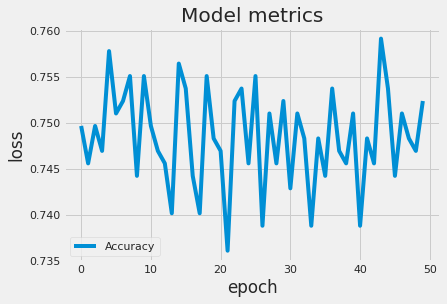

In [27]:
def train_model():
  train_label = np.array(pd.get_dummies(train_data_y))
  test_label = np.array(pd.get_dummies(test_data_y))
  hist = model.fit(x = train_data_x,
                   y = train_label,
                   batch_size = 64,
                   epochs=50,
                   verbose=1,
                   callbacks=callbacks,
                   validation_data=(test_data_x, test_label))

  plt.plot(hist.history['accuracy'])
  # plt.plot(hist.history['loss'])
  plt.title('Model metrics')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # plt.legend(['Lccuracy', 'Loss'], loc='best')
  plt.legend(['Accuracy'], loc='best')
  plt.show()

train_model()
     

# Libraries

In [ ]:
!rm -r content

In [ ]:
!pip install \
    --platform manylinux2014_x86_64 \
    --target=content \
    --implementation cp \
    --python 3.8 \
    --only-binary=:all: --upgrade \
    torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.3 MB/s eta 0:00:43tcmalloc: large alloc 1147494400 bytes == 0x39b0c000 @  0x7f762b7c3615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |████████████████████████████████| 890.2 MB 4.6 kB/s 
     |████████████████████████████████| 317.1 MB 22 kB/s 
     |████████████████████████████████| 21.0 MB 5.2 MB/s 
     |████████████████████████████████| 557.1 MB 7.9 kB/s 
     |████████████████████████████████| 849 kB 56.8 MB/s 
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of t

In [ ]:
!pip install -t ./content/ librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 8.1 MB/s 
     |████████████████████████████████| 377 kB 55.3 MB/s 
     |████████████████████████████████| 33.8 MB 302 kB/s 
     |████████████████████████████████| 3.5 MB 41.6 MB/s 
     |████████████████████████████████| 3.1 MB 47.4 MB/s 
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
     |████████████████████████████████| 31.2 MB 1.3 MB/s 
     |████████████████████████████████| 297 kB 66.7 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 17.1 MB 12 kB/s 
  Using cached importlib_metadata-5.1.0-py3-none-any.whl (21 kB)
     |████████████████████████████████| 34.6 MB 230 kB/s 
     |████████████████████████████████| 1.2 MB 59.3 MB/s 
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached certifi-2022.9.24-py

In [ ]:
!pip install -t ./s3/ s3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 9.1 MB 8.0 MB/s 
     |████████████████████████████████| 140 kB 40.7 MB/s 
     |████████████████████████████████| 155 kB 42.9 MB/s 
     |████████████████████████████████| 61 kB 60 kB/s 
     |████████████████████████████████| 548 kB 43.4 MB/s 
     |████████████████████████████████| 3.2 MB 36.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 133 kB 47.3 MB/s 
     |████████████████████████████████| 121 kB 24.4 MB/s 
     |████████████████████████████████| 90 kB 10.1 MB/s 
     |████████████████████████████████| 9.5 MB 48.9 MB/s 
     |████████████████████████████████| 93 kB 399 kB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB

In [ ]:
!pip install \
    --platform manylinux2014_x86_64 \
    --target=content \
    --implementation cp \
    --python 3.8 \
    --only-binary=:all: --upgrade \
    pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 956 kB/s 


In [ ]:
!zip -r s3.zip ./s3/

Streaming output truncated to the last 5000 lines.
  adding: s3/sphinxcontrib/devhelp/locales/nb_NO/LC_MESSAGES/ (stored 0%)
  adding: s3/sphinxcontrib/devhelp/locales/nb_NO/LC_MESSAGES/sphinxcontrib.devhelp.po (deflated 42%)
  adding: s3/sphinxcontrib/devhelp/locales/nb_NO/LC_MESSAGES/sphinxcontrib.devhelp.mo (deflated 44%)
  adding: s3/sphinxcontrib/devhelp/locales/de/ (stored 0%)
  adding: s3/sphinxcontrib/devhelp/locales/de/LC_MESSAGES/ (stored 0%)
  adding: s3/sphinxcontrib/devhelp/locales/de/LC_MESSAGES/sphinxcontrib.devhelp.po (deflated 43%)
  adding: s3/sphinxcontrib/devhelp/locales/de/LC_MESSAGES/sphinxcontrib.devhelp.mo (deflated 45%)
  adding: s3/sphinxcontrib/devhelp/locales/sv/ (stored 0%)
  adding: s3/sphinxcontrib/devhelp/locales/sv/LC_MESSAGES/ (stored 0%)
  adding: s3/sphinxcontrib/devhelp/locales/sv/LC_MESSAGES/sphinxcontrib.devhelp.po (deflated 43%)
  adding: s3/sphinxcontrib/devhelp/locales/sv/LC_MESSAGES/sphinxcontrib.devhelp.mo (deflated 45%)
  adding: s3/sphinxco

In [ ]:
!du -sh s3

85M	s3


In [ ]:
!du -sh s3.zip

29M	s3.zip


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!ls /gdrive

MyDrive


In [ ]:
!cp content.zip /gdrive/MyDrive/